# Demostrate spotting the difference between images

### Imports

In [1]:
import cv2 as cv
import numpy as np  
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pytesseract
from PIL import Image

In [2]:
!where tesseract

C:\datascience\python\envs\tesseract\Library\bin\tesseract.exe


In [3]:
pytesseract.pytesseract.tesseract_cmd = r'C:\datascience\python\envs\tesseract\Library\bin\tesseract.exe'
# os.environ['TESSDATA_PREFIX'] = r'C:\datascience\python\envs\tesseract\Library\bin'
tessdata_dir_config = r'--tessdata-dir "C:\datascience\python\envs\tesseract\Library\bin\tessdata"'

## Task

```
Give two almost identical screenshot of a webpage, the program should highlight
the differences between two images (What is new and what is missing)
```

- Spot the difference between images of webpages
- Images are screenshot capturing whole visible window of webpage
- Webpage images can by misaligned by scrolling up/down
- Since it is screenshot reading HTML is out of scope

# Samples

In [4]:
images=[]
for fname in os.listdir("data/sample/"):
    images.append(cv.cvtColor(cv.imread(f"data/sample/{fname}"),cv.COLOR_BGR2RGB))

## add vertical shifts
# images.append(cv.copyMakeBorder(images[0],top=50,bottom=0,left=0,right=0,borderType=cv.BORDER_CONSTANT)[0:-50,...])
# images.append(cv.copyMakeBorder(images[0],top=0,bottom=80,left=0,right=0,borderType=cv.BORDER_CONSTANT)[80:,...])

## Method

Code for alignment, detecting differences and reading text.

In [5]:
def align1(im1,im2,plot=False,MAX_FEATURES = 500,GOOD_MATCH_PERCENT = 0.15, eps=None, vertical=False):
    # Detect ORB features and compute descriptors.
    orb = cv.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    # Match features.
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    imMatches = cv.drawMatches(im1, keypoints1, im2, keypoints2, matches, None) 
    
    if plot:
        plt.figure(figsize=(30,8))
        plt.imshow(imMatches)
        plt.show()

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    if vertical:
        h = np.eye(3)
        h[1,2] = np.median(points2-points1,axis=0)[1]
    else:
        h, mask = cv.findHomography(points1, points2, cv.RANSAC)
        if eps:
            h = np.round(h,decimals=eps)
            
    # Use homography
    height, width = im2.shape[0:2]
    im1Reg = cv.warpPerspective(im1, h, (width, height))
    return im1Reg,h

In [6]:
def detect_diff(im1,im2,low=10, blur_ksize=0, closing_kernel=5,**kwargs):
#     im1 = cv.cvtColor(im1,cv.COLOR_BGR2GRAY)
#     im2 = cv.cvtColor(im2,cv.COLOR_BGR2GRAY)
    im1Reg,h = align1(im1,im2,**kwargs)
#     diff = np.abs(im1Reg.astype(np.int32)-im2.astype(np.int32)).astype(np.uint8)
    diff = np.abs(cv.cvtColor(im1Reg,cv.COLOR_RGB2GRAY).astype(np.int32)-cv.cvtColor(im2,cv.COLOR_RGB2GRAY).astype(np.int32)).astype(np.uint8)
    if blur_ksize>0:
        diff = cv.medianBlur(diff,ksize=blur_ksize)
    
    _,diff = cv.threshold(diff,low,255,cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (closing_kernel, 1))
    diff = cv.morphologyEx(diff, cv.MORPH_CLOSE, kernel)
    contours, hierarchy = cv.findContours(diff, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    print(f"Found {len(contours)} differences.")
    fig, ax = plt.subplots(1,2,figsize=(30,8))
    ax[0].imshow(im2,cmap='gray')
    full_diff = cv.cvtColor(im1Reg,cv.COLOR_RGB2GRAY).astype(np.int32)-cv.cvtColor(im2,cv.COLOR_RGB2GRAY).astype(np.int32)
    aximg = ax[1].imshow((full_diff.astype(np.float64)+255)/(255*2),cmap='bwr',vmin=0, vmax=1)
    plt.colorbar(aximg)
    boxes = list(map(lambda cnt: cv.boundingRect(cnt),contours))
    for cnt,box in zip(contours,boxes):
        x,y,w,h = box
        box_diff = full_diff[y:(y+h),x:(x+w)]
        if np.sum(box_diff>0)>np.sum(box_diff<0):
            edgecolor='r'
        else:
            edgecolor='b'
        ax[0].add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none'))
        ax[1].add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none'))
    #     ax.plot(cnt[:,0,0],cnt[:,0,1],'r-')
    plt.show()
    return boxes,im1Reg

In [20]:
def read_box(box,im1,im2,padx=0,pady=0,pad=1):
    x,y,w,h = box
    im1_padded = cv.copyMakeBorder(im1[(y-pad):(y+h+pad),(x-pad):(x+w+pad)],
                                   top=pady,bottom=pady,left=padx,right=padx,borderType=cv.BORDER_REPLICATE)
    im2_padded = cv.copyMakeBorder(im2[(y-pad):(y+h+pad),(x-pad):(x+w+pad)],
                                   top=pady,bottom=pady,left=padx,right=padx,borderType=cv.BORDER_REPLICATE)

    fig, ax = plt.subplots(1,2,figsize=(30,8))

    ax[0].imshow(im1_padded)
    ax[1].imshow(im2_padded)
    plt.show()
    print(pytesseract.image_to_string(im1_padded, lang='eng',config=tessdata_dir_config))
    print(pytesseract.image_to_string(im2_padded, lang='eng',config=tessdata_dir_config))

## Examples

### Control case - no diff

In [8]:
im1=images[0]
im2=images[0]

original images


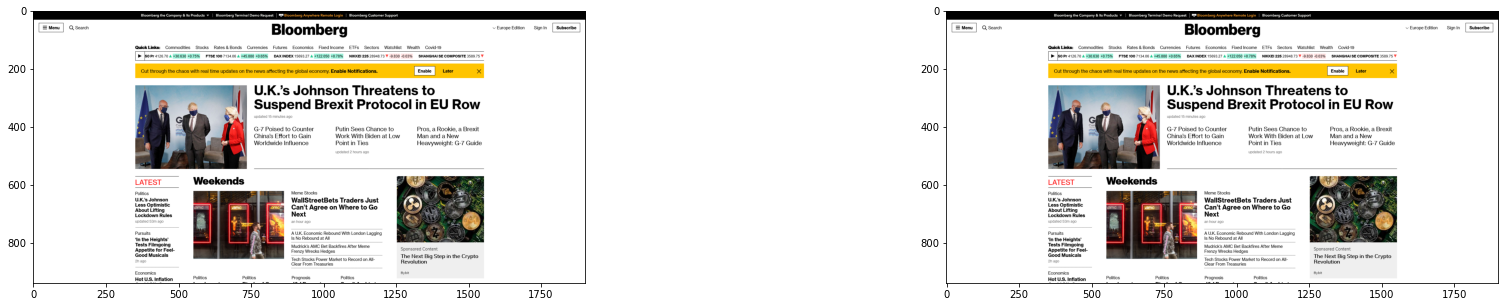

Align by matching


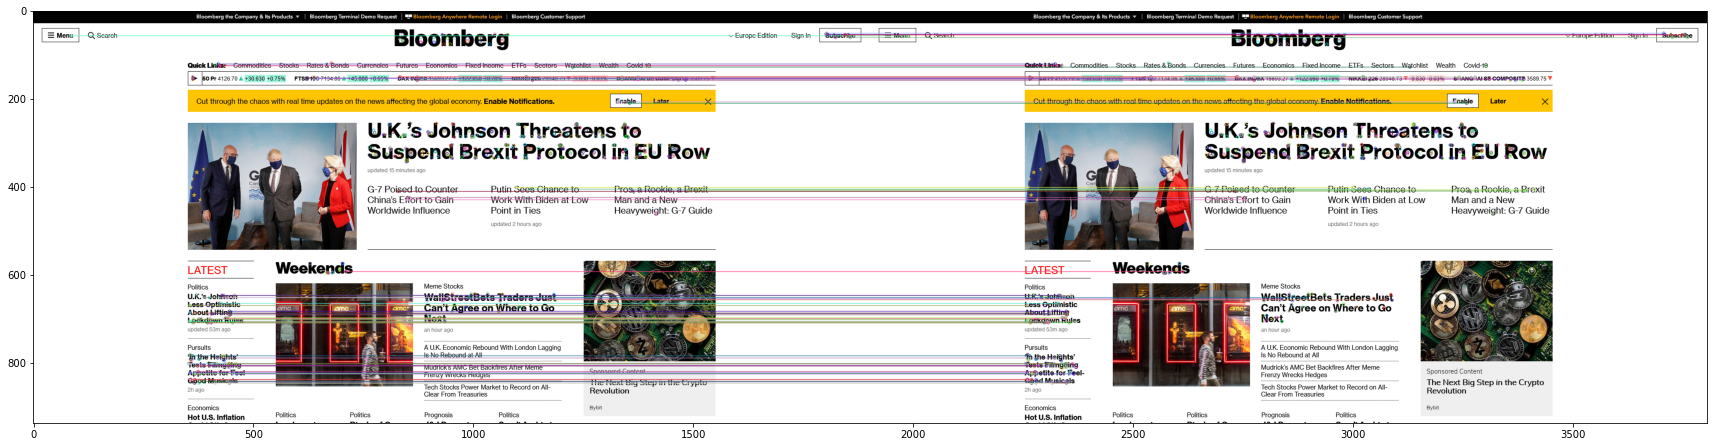

Found 0 differences.


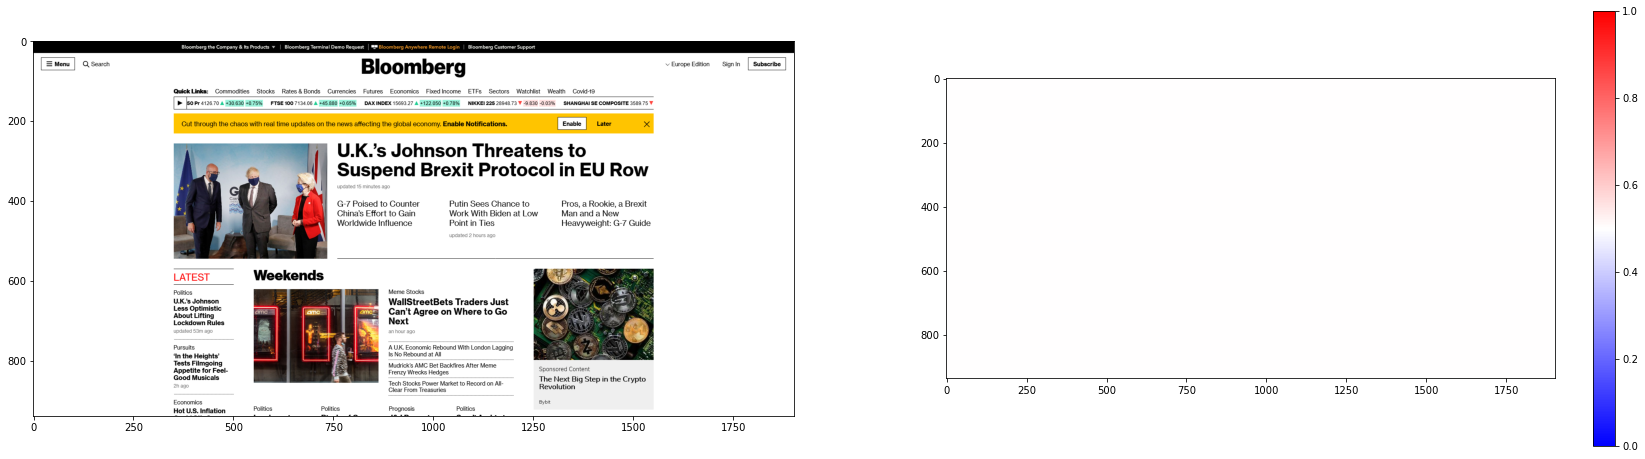

In [9]:
print("original images")
fig,axs=plt.subplots(1,2,figsize=(30,5))
axs[0].imshow(im1)
axs[1].imshow(im2)
plt.show()
print("Align by matching")
bxs,im1_aligned = detect_diff(im1,im2,low=10, blur_ksize=0,plot=True,vertical=True)

### Scroll down

In [10]:
im1=images[5]
im2=images[6]

original images


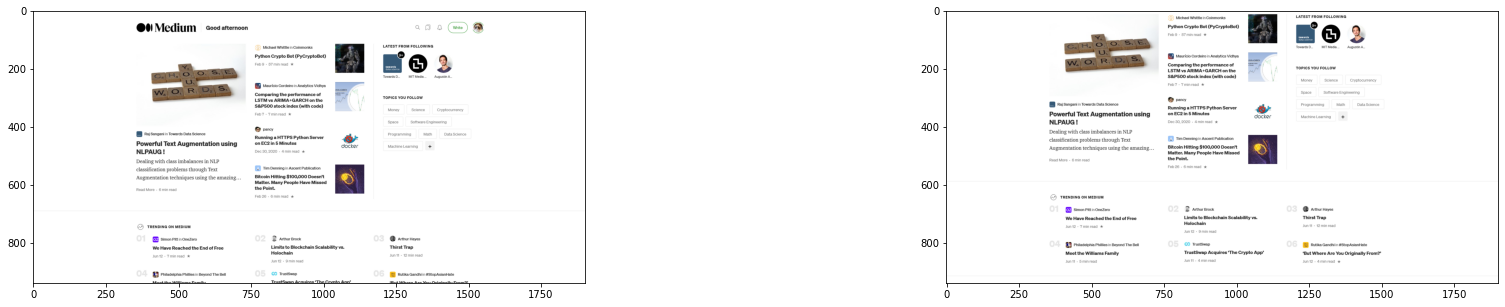

Align by matching


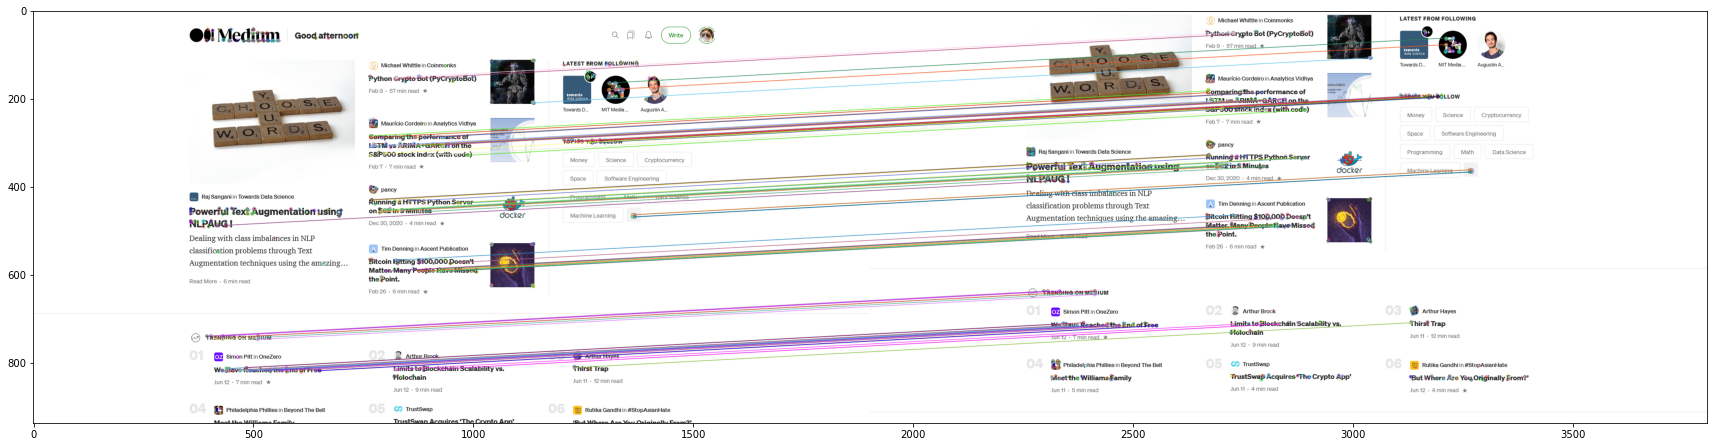

Found 1 differences.


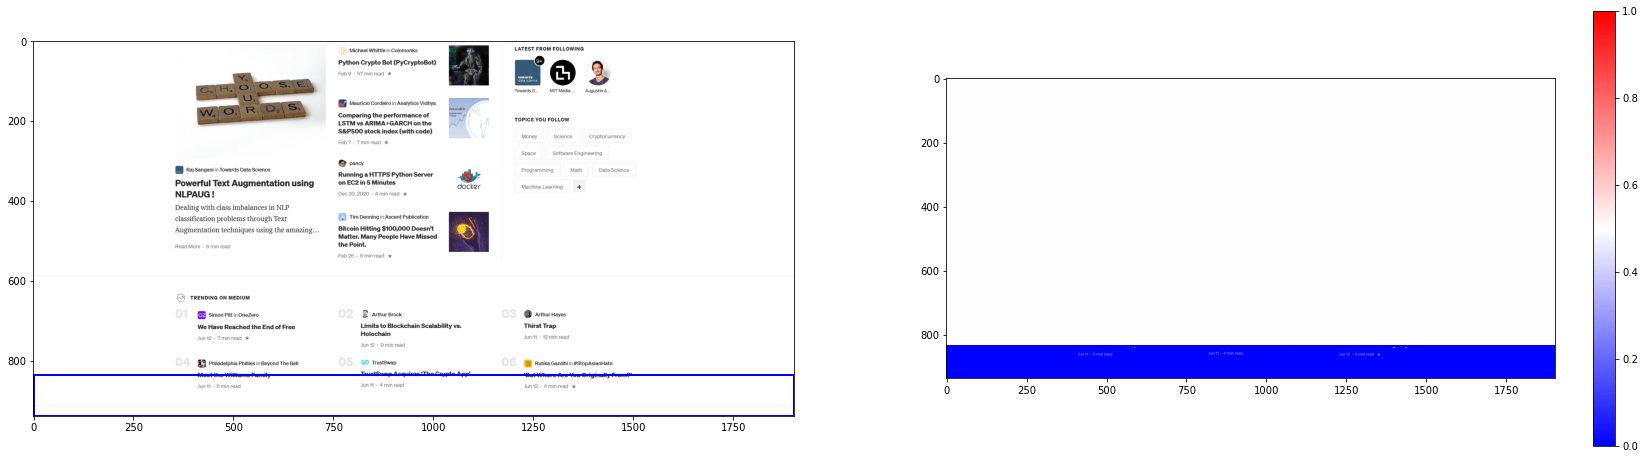

In [11]:
print("original images")
fig,axs=plt.subplots(1,2,figsize=(30,5))
axs[0].imshow(im1)
axs[1].imshow(im2)
plt.show()
print("Align by matching")
bxs,im1_aligned = detect_diff(im1,im2,low=10, blur_ksize=0,plot=True,vertical=True)

### Moving text

In [21]:
im1=images[1]
im2=images[3]

original images


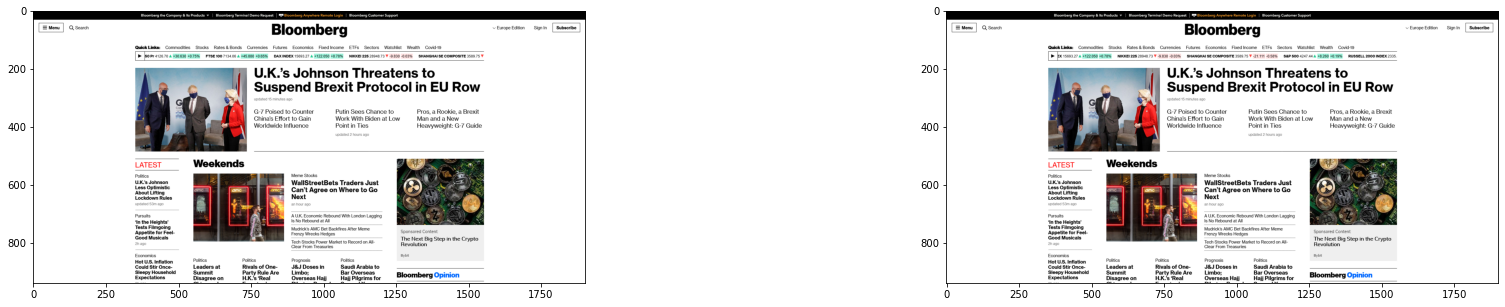

Align by matching


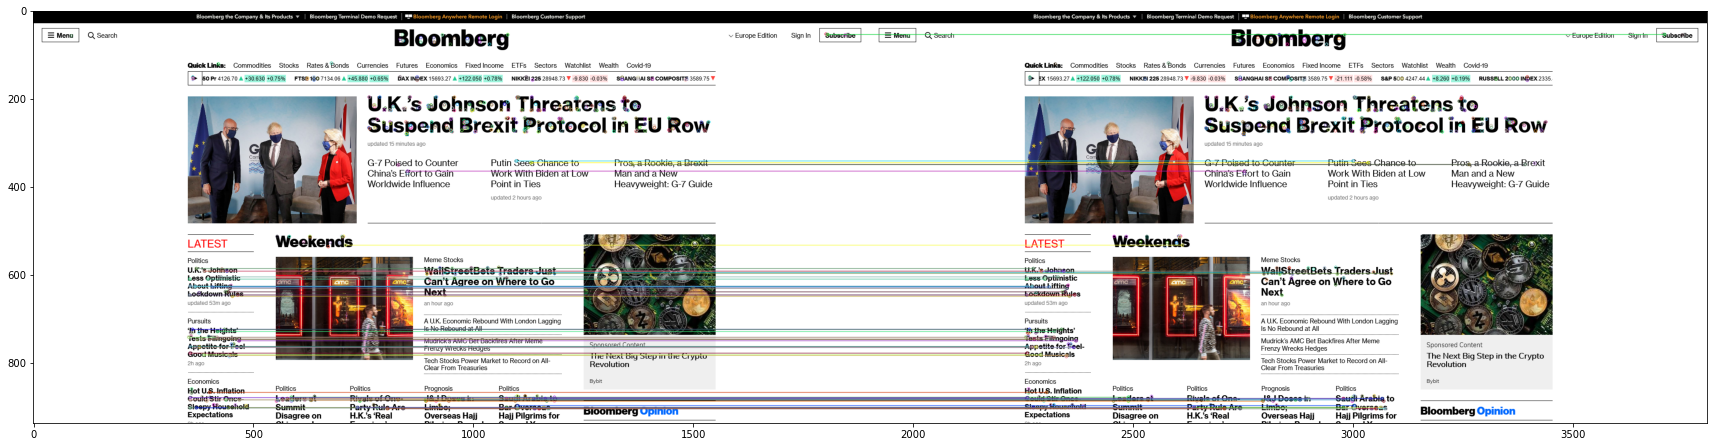

Found 3 differences.


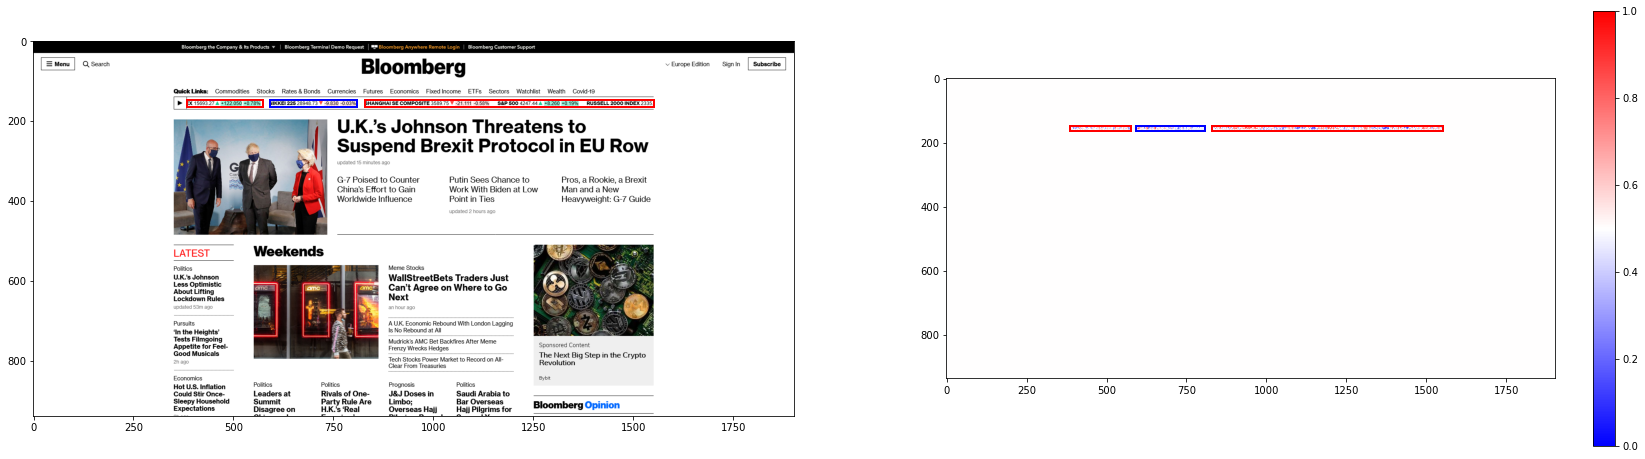

In [22]:
print("original images")
fig,axs=plt.subplots(1,2,figsize=(30,5))
axs[0].imshow(im1)
axs[1].imshow(im2)
plt.show()
print("Align by matching")
bxs,im1_aligned = detect_diff(im1,im2,low=10, blur_ksize=0,closing_kernel=15,plot=True,vertical=True)

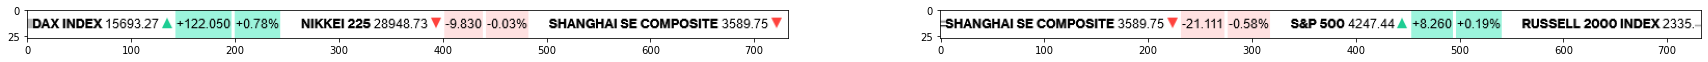

DAX INDEX 1569327 A +122.050 +078% NIKKEI 225 28943.73 V -9.830 -0.03% SHANGHAI SE COMPOSITE 3589.75 V.

“SHANGHAI SE COMPOSITE 3580.75 V 21.111 0.58% S&P 500 4247.44 A +8260 +0.19% RUSSELL 2000 INDEX 2335,



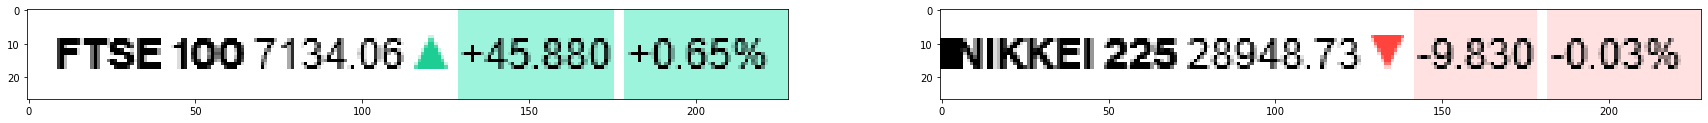

FTSE100 7134.06 A +45.880 +0.65%

NIKKEI 225 28943.73 V 0.830 -0.03%



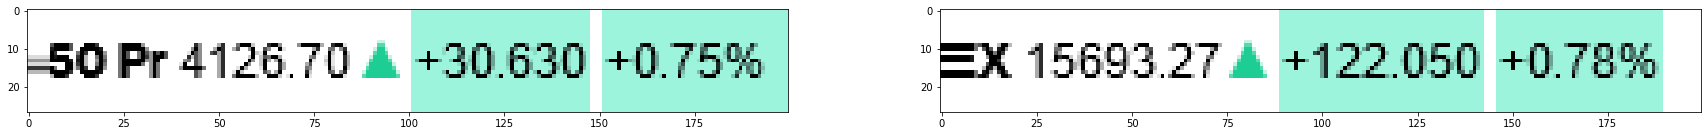

50 Pr 4126.70 A +30.630 +0.75%

=X 15693.27 A +122.050 +0.78%



In [25]:
for box in bxs:
    read_box(box,im1_aligned,im2,padx=5,pady=5,pad=0)

### New div

In [15]:
im1=images[8]
im2=images[7]

original images


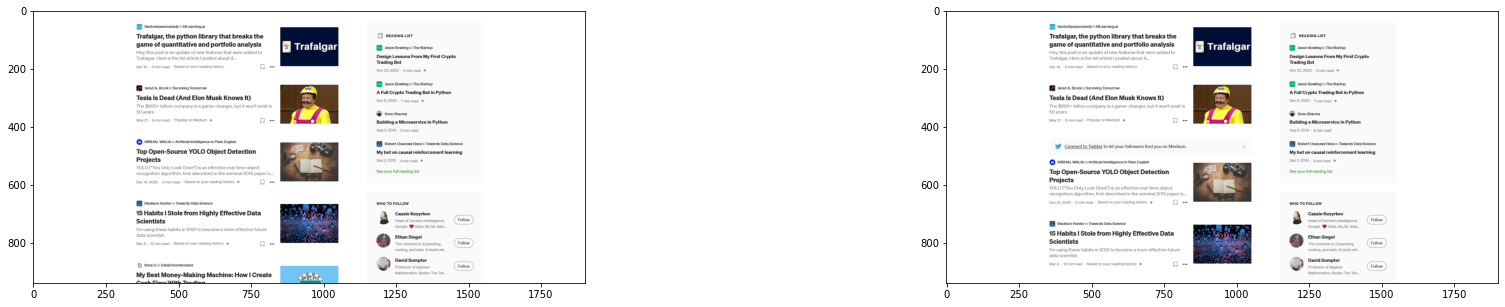

Align by matching


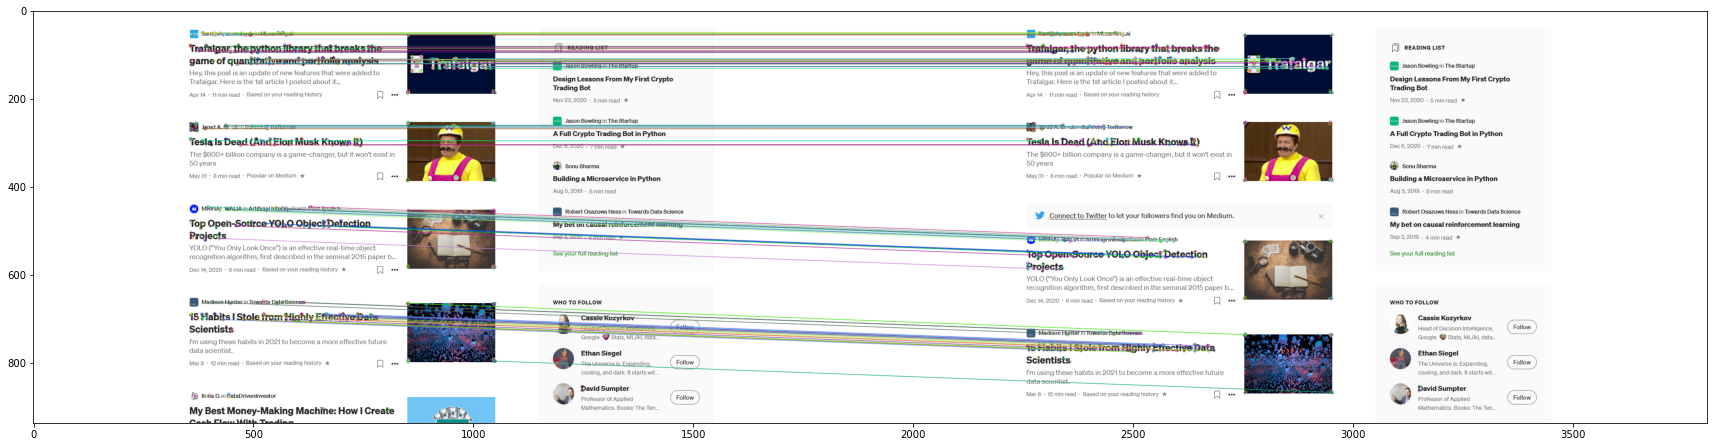

Found 37 differences.


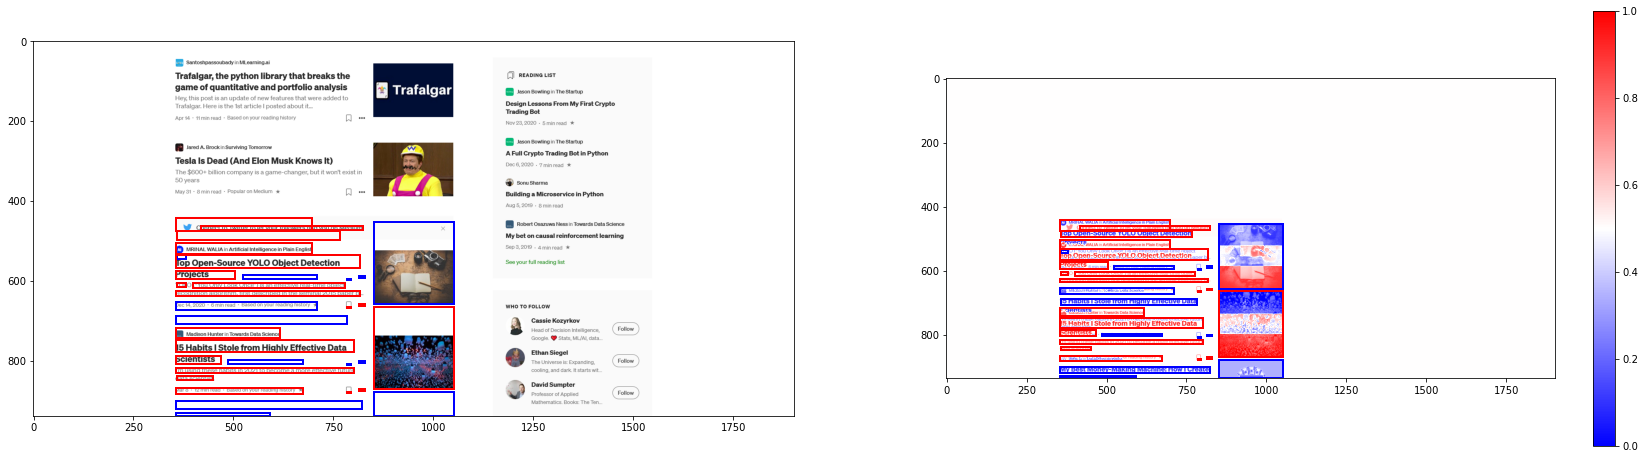

In [16]:
print("original images")
fig,axs=plt.subplots(1,2,figsize=(30,5))
axs[0].imshow(im1)
axs[1].imshow(im2)
plt.show()
print("Align by matching")
bxs,im1_aligned = detect_diff(im1,im2,low=10, blur_ksize=5, closing_kernel=15,plot=True,vertical=True)